# 波动方程

这里面没有太多编程技巧，主要是我对手头的基本教材做个笔记。

波动方程某种意义上说是简谐运动的多维度扩展。

## 均匀弦的横向振动

简单的考虑一维弦上的振动，例如吉他弦。会得到一个非常简练的二阶偏微分方程：

$$
\rho \frac{d^2u}{dt^2}=\frac{\partial}{\partial x}(Tsin\varphi)
$$

在这里，T是振动系数，$\varphi$ 是弦密度。

接下来我们先初始化方程的基本设置，和之前讨论的对二阶微分方程的讨论一样，我们通过一阶微分方程，次第表达二阶方程。

In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# 参数设置
L = 32.0        # 弦的长度
N = 256         # 空间离散点数
dx = L / (N-1) # 空间步长
T = 3.14       # 张力
rho = 2.72      # 密度

# CasADi 变量
u = ca.MX.sym('u', N)      # 位移
v = ca.MX.sym('v', N)      # 速度



经过两级联立，我们可以得到最终的波动方程

In [2]:
# 偏导角度 phi ≈ du/dx，用中心差分计算 sin(phi)
def sin_phi(u):
    phi = (u[2:] - u[:-2]) / (2*dx)
    return ca.vertcat(ca.DM(0), ca.sin(phi), ca.DM(0))  # 边界为0

# 构建 du/dt = v，dv/dt = 1/rho * d/dx(T*sin(phi))
sinphi = sin_phi(u)
Tsinphi = T * sinphi

# 对 T*sin(phi) 求一阶导数，用中心差分
dTsinphi_dx = ca.vertcat(
    (Tsinphi[1] - Tsinphi[0]) / dx,
    (Tsinphi[2:] - Tsinphi[:-2]) / (2*dx),
    (Tsinphi[-1] - Tsinphi[-2]) / dx
)

du_dt = v
dv_dt = (1/rho) * dTsinphi_dx



现在，我们可以组装ODE系统。这部分没有太复杂的东西。

In [3]:
# ODE 系统
x = ca.vertcat(u, v)
xdot = ca.vertcat(du_dt, dv_dt)

# 构建 CasADi integrator
ode = {'x': x, 'ode': xdot}
opts = {'tf': 0.01}
integrator = ca.integrator('integrator', 'cvodes', ode, opts)


CasADi - 2025-05-29 19:23:15 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:698]


仿真过程也是。

In [4]:
# 初始条件：在中间一个小高斯扰动
x0_u = np.zeros(N)
x0_u[N//2] = 0.618
x0_v = np.zeros(N)
x0 = np.concatenate([x0_u, x0_v])

# 仿真参数
n_steps = 3000
results = [x0_u.copy()]

xk = x0
for _ in range(n_steps):
    res = integrator(x0=xk)
    xk = res['xf'].full().flatten()
    results.append(xk[:N].copy())

但是要在二维屏幕上显示（时间, 弦, 波动位移）这三个维度，稍微有点儿麻烦。我们可以用颜色表示唯一。

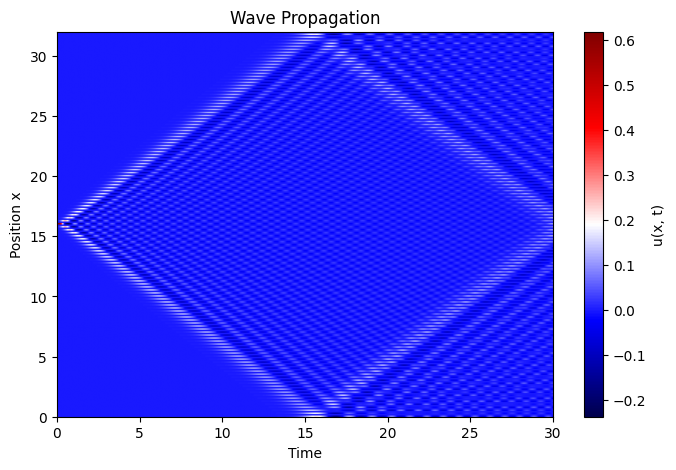

In [5]:
# 可视化
results = np.array(results)
X = np.linspace(0, L, N)
T_plot = np.linspace(0, n_steps * opts['tf'], n_steps+1)

plt.figure(figsize=(8, 5))
plt.imshow(results.T, extent=[0, T_plot[-1], 0, L], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar(label='u(x, t)')
plt.xlabel('Time')
plt.ylabel('Position x')
plt.title('Wave Propagation')
plt.show()

也可以做一个动画版。这里用到 ipympl 。如果没有的话，先安装一下。

```
pip install ipympl
```

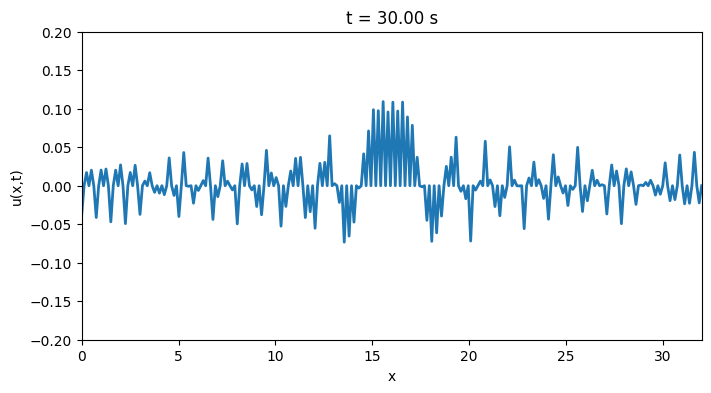

In [6]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 4))
x_vals = np.linspace(0, L, N)
line, = ax.plot(x_vals, results[0], lw=2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlim(0, L)
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.set_title("Nonlinear Wave Propagation")

def update(frame):
    line.set_ydata(results[frame])
    ax.set_title(f"t = {frame * opts['tf']:.2f} s")
    return line,

ani = FuncAnimation(fig, update, frames=len(results), interval=30, blit=True)
HTML(ani.to_html5_video())


当然，动画版更为形象，不过要做深入的定量分析，可能热力图更方便。我们不用等待演化过程完整播放出来，就可以演时间轴观察到振动的阔

## 均匀杆的纵向运动

## 传输线方程

## 均匀薄膜的微小横振动